In [1]:
import tensorflow as tf
print("Versión de TensorFlow:", tf.__version__)

2025-05-27 20:46:20.205836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Versión de TensorFlow: 2.10.0


In [1]:
#Esto instalará las librerías en el entorno actual (tf_keras).luego reiniciar kernel
import sys
!{sys.executable} -m pip install scikit-learn matplotlib

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Oculta avisos de CPU (pero muestra errores reales)
import tensorflow as tf

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from keras.optimizers import Adam  
from tensorflow.keras.layers import Conv2D,  AveragePooling2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import Callback


Vizualisar las imágenes

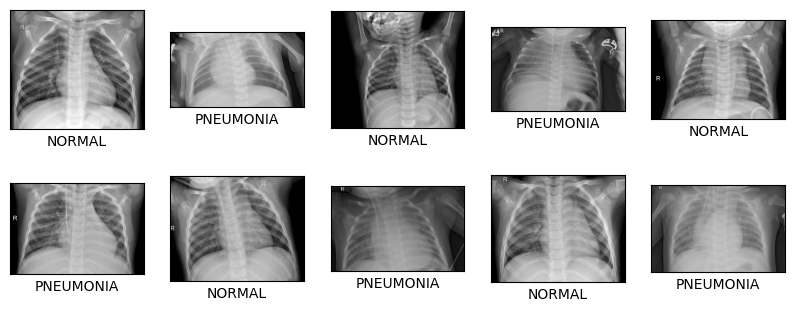

In [19]:
import os
import matplotlib.pyplot as plt
from PIL import Image
class_names = ['NORMAL', 'PNEUMONIA']
train_dir = f'{base_path}/train'

normal = os.listdir(f'{train_dir}/NORMAL')
pneumonia = os.listdir(f'{train_dir}/PNEUMONIA')

# Mezclamos imágenes de ambas clases
images = [(f'{train_dir}/NORMAL/{normal[i]}', 0) if i % 2 == 0 else (f'{train_dir}/PNEUMONIA/{pneumonia[i]}', 1) for i in range(25)]

plt.figure(figsize=(10,10))
for i in range(10):
    img = Image.open(images[i][0])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.xlabel(class_names[images[i][1]])
plt.show()


In [8]:
# hiperparámetros 
img_width, img_height = 150, 150 # ajusta El tamaño de las imágenes 
epochs = 15 #veces que el modelo recorrerá todo el conjunto de entrenamiento

# DATA AUGMENTATION  
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normaliza valores a 0–1
    rotation_range=20,          # Rota imágenes al azar (hasta ±20°)
    width_shift_range=0.2,      # Desplaza horizontal
    height_shift_range=0.2,     # Desplaza vertical
    shear_range=0.25,            # Deforma la imagen diagonalmente
    zoom_range=0.2,             # Aplica zoom aleatorio
    horizontal_flip=True,        # Voltea horizontalmente
# --- Nuevas adiciones/ajustes ---
    brightness_range=[0.8, 1.2], # Cambia el brillo de la imagen
    channel_shift_range=50, # Cambia los valores de los canales RGB
)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
     '/home/variante/ProyectosPython/PROYECTONEU2/DATOS235/train',
    target_size=(img_width, img_height),#define las dimensiones a las que se redimensionarán todas las imágenes antes de ser alimentadas a la red neuronal.
    batch_size=16, #número de muestras de entrenamiento que el modelo procesa en una sola iteración antes de actualizar sus pesos.
    class_mode='binary' #  el tipo de salida (binario), 
)

val_generator = val_datagen.flow_from_directory(
     '/home/variante/ProyectosPython/PROYECTONEU2/DATOS235/val/',
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='binary'
)


Found 476 images belonging to 2 classes.
Found 481 images belonging to 2 classes.


In [9]:
#Filtros y neuronas 

model = Sequential([
    # Primera capa convolucional: 
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Segunda capa convolucional: 
    Conv2D(54, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Tercera capa convolucional: 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Capas finales
    Flatten(),
    Dropout(0.6), 
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.005))
])
#BatchNormalization() → ayuda a estabilizar el entrenamiento.
#Dropout(0.5) → reduce sobreajuste apagando conexiones aleatoria
# sumar L2 regularization en las capas Dense, por el sobreajuste.

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 54)        15606     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 54)       0         
 2D)                                                             
                                                        

In [11]:
# 4. COMPILACIÓN del Modelo 

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    optimizer=Adam(learning_rate=0.00005), 
    loss='binary_crossentropy',  #para clasificación binaria    
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']  
)
#  5. Configuración de Callbacks (Acá Early Stopping)
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitoreamos la pérdida en el conjunto de validación
    patience=10,               # Espera 10 épocas sin mejora en val_loss
    restore_best_weights=True  # Vuelve a la época con la mejor val_loss
)

In [12]:
# 6. ENTRENAMIENTO del Modelo (Aplicamos Early Stopping) ---
print("Iniciando entrenamiento...")
history = model.fit(
    train_generator,  #X
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40, # Podemos poner un número alto, EarlyStopping lo detendrá automáticamente
    validation_data=val_generator, 
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping] # Pasamos el callback aquí
)
print("Entrenamiento finalizado.")

Iniciando entrenamiento...
Epoch 1/40
29/29 [==============================] - 205s 7s/step - loss: 2.0327 - accuracy: 0.7065 - precision: 0.7093 - recall: 0.7000 - auc: 0.7924 - val_loss: 2.1075 - val_accuracy: 0.5063 - val_precision: 0.5063 - val_recall: 1.0000 - val_auc: 0.9237
Epoch 2/40
29/29 [==============================] - 153s 5s/step - loss: 1.8103 - accuracy: 0.7931 - precision: 0.7922 - recall: 0.7922 - auc: 0.8687 - val_loss: 2.1345 - val_accuracy: 0.5063 - val_precision: 0.5063 - val_recall: 1.0000 - val_auc: 0.8637
Epoch 3/40
29/29 [==============================] - 128s 4s/step - loss: 1.7426 - accuracy: 0.7978 - precision: 0.7801 - recall: 0.8246 - auc: 0.8831 - val_loss: 2.3472 - val_accuracy: 0.5063 - val_precision: 0.5063 - val_recall: 1.0000 - val_auc: 0.8900
Epoch 4/40
29/29 [==============================] - 118s 4s/step - loss: 1.6491 - accuracy: 0.8435 - precision: 0.8605 - recall: 0.8150 - auc: 0.9229 - val_loss: 3.2498 - val_accuracy: 0.5063 - val_precision:

In [16]:
# Evaluación
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset de prueba (test)
test_datagen = ImageDataGenerator(rescale=1./255)
# Le dice al generador que normalice los valores de los píxeles de todas las imágenes. 
#Las imágenes suelen tener valores de píxeles entre 0 y 255. Al dividir cada píxel por 255, estos valores se escalan a un rango entre 0.0 y 1.0.

test_generator = test_datagen.flow_from_directory(
    '/home/variante/ProyectosPython/PROYECTONEU2/DATOS235/test/',
    target_size=(img_width, img_height),
    class_mode='binary'
)
metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

# Evaluación del modelo
loss, accuracy, precision, recall, auc = model.evaluate(test_generator)
print(f"\nResultados Finales del Modelo en Test:")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  AUC: {auc:.4f}")



Found 468 images belonging to 2 classes.
15/15 [==============================] - 31s 2s/step - loss: 2.1249 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - auc: 0.8238

Resultados Finales del Modelo en Test:
  Loss: 2.1249
  Accuracy: 0.5000
  Precision: 0.5000
  Recall: 1.0000
  AUC: 0.8238


Con estos resultados en el conjunto de prueba (Loss: 2.1249, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, AUC: 0.8238), la conclusión es que el modelo no aprendió a clasificar la neumonía de forma útil.

El Accuracy del 50% y la Precision del 50% combinados con un Recall del 100% (para una de las clases) indican un sobreajuste severo. Esto significa que el modelo está prediciendo consistentemente una sola clase (en este caso, parece ser "Neumonía") para todas las imágenes en el conjunto de prueba. No está aprendiendo a distinguir entre "Normal" y "Neumonía", sino que simplemente memorizó una de las clases de entrenamiento.

Este comportamiento ya lo habías observado durante la validación y ahora se confirma en la prueba. Reafirma que, para tu dataset limitado, entrenar una CNN desde cero no es efectivo.

In [17]:
# Predicciones:

from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 150, 150 

# la ruta de la carpeta
test_dir = '/home/variante/ProyectosPython/PROYECTONEU2/DATOS235/test/'

# Cargamos imágenes de ambas clases
paths = []
labels = []

for label in ['NORMAL', 'PNEUMONIA']:
    folder = os.path.join(test_dir, label)
    for fname in os.listdir(folder)[:10]:  # Tomamos 10 de cada clase
        paths.append(os.path.join(folder, fname))
        labels.append(label)

# Predecimos
for path, true_label in zip(paths, labels):
    img = load_img(path, target_size=(img_width, img_height))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = 'PNEUMONIA' if prediction[0][0] > 0.5 else 'NORMAL'
    
    print(f"✅ Imagen: {os.path.basename(path)} | Real: {true_label} | Predicción: {predicted_class} | Prob: {prediction[0][0]:.2f}")



1/1 [==============================] - 1s 857ms/step
✅ Imagen: IM-0009-0001.jpeg | Real: NORMAL | Predicción: PNEUMONIA | Prob: 0.76
1/1 [==============================] - 0s 486ms/step
✅ Imagen: NORMAL2-IM-0041-0001.jpeg | Real: NORMAL | Predicción: PNEUMONIA | Prob: 0.77
1/1 [==============================] - 0s 280ms/step
✅ Imagen: NORMAL2-IM-0207-0001.jpeg | Real: NORMAL | Predicción: PNEUMONIA | Prob: 0.76
1/1 [==============================] - 0s 362ms/step
✅ Imagen: IM-0029-0001.jpeg | Real: NORMAL | Predicción: PNEUMONIA | Prob: 0.76
1/1 [==============================] - 0s 226ms/step
✅ Imagen: IM-0015-0001.jpeg | Real: NORMAL | Predicción: PNEUMONIA | Prob: 0.76
1/1 [==============================] - 0s 215ms/step
✅ Imagen: IM-0019-0001.jpeg | Real: NORMAL | Predicción: PNEUMONIA | Prob: 0.76
1/1 [==============================] - 0s 211ms/step
✅ Imagen: IM-0046-0001.jpeg | Real: NORMAL | Predicción: PNEUMONIA | Prob: 0.76
1/1 [==============================] - 0s 199ms/step


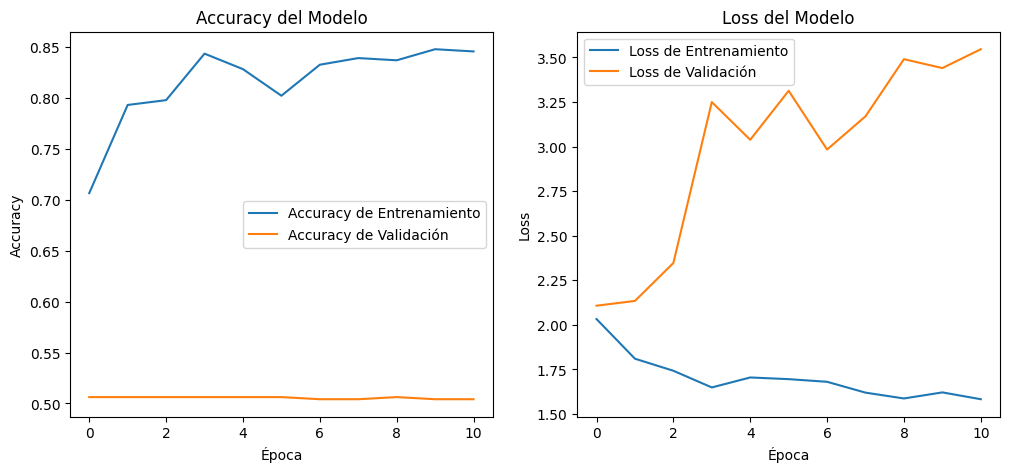

In [20]:
# Gráficas de Rendimiento ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Accuracy del Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.title('Loss del Modelo')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()

plt.show()